## 2014-2019 Sample sale transactional data of 57 drugs classified as:

M01AB - Anti-inflammatory and antirheumatic products, non-steroids, Acetic acid derivatives and related substances
M01AE - Anti-inflammatory and antirheumatic products, non-steroids, Propionic acid derivatives
N02BA - Other analgesics and antipyretics, Salicylic acid and derivatives
N02BE/B - Other analgesics and antipyretics, Pyrazolones and Anilides
N05B - Psycholeptics drugs, Anxiolytic drugs
N05C - Psycholeptics drugs, Hypnotics and sedatives drugs
R03 - Drugs for obstructive airway diseases
R06 - Antihistamines for systemic use
- Sales data are resampled to the hourly, daily, weekly and monthly periods. 
- Data is already pre-processed, where processing included outlier detection and treatment and missing data imputation.

ATC codes features are added to the dataset, namely a model has been transformed as indicated on the image below and data was resampled to the hourly time-series.

Sales Transations: DateTime, Brand Name, Quantity
Hourly Sales data: Hour, Quantity: M01AB, M01AE,N02BA,N02BE/B, N05B,N05C,R03 & R06

In [32]:
import numpy as np
from numpy import array
import pandas as pd
from pandas import concat
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import ParameterGrid


In [25]:
pd.plotting.register_matplotlib_converters()

warnings.filterwarnings("ignore")

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [34]:
# Import csv files
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
# Files to Load
daily = "Resources/salesdaily.csv"
hourly ="Resources/saleshourly.csv"
monthly ="Resources/salesmonthly.csv"
weekly ="Resources/salesweekly.csv"

In [35]:
dailydf = pd.read_csv(daily)
dailydf.head(3)

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday_Name,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,1/2/2014,0.0,3.67,3.4,32.40,7.0,0.0,0.0,2.0,2014,1,248,Thursday,NaN,NaN,NaN,NaN,NaN,NaN
1,1/3/2014,8.0,4.00,4.4,50.60,16.0,0.0,20.0,4.0,2014,1,276,Friday,NaN,NaN,NaN,NaN,NaN,NaN
2,1/4/2014,2.0,1.00,6.5,61.85,10.0,0.0,9.0,1.0,2014,1,276,Saturday,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
hourlydf = pd.read_csv(hourly)
hourlydf.head(3)

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014 8:00,0.0,0.67,0.4,2.0,0.0,0.0,0.0,1.0,2014,1,8,Thursday
1,1/2/2014 9:00,0.0,0.00,1.0,0.0,2.0,0.0,0.0,0.0,2014,1,9,Thursday
2,1/2/2014 10:00,0.0,0.00,0.0,3.0,2.0,0.0,0.0,0.0,2014,1,10,Thursday


In [29]:
monthlydf = pd.read_csv(monthly)
monthlydf.head(3)

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,2014-01-31,127.69,99.09,152.100,878.030,354.0,50.0,112.0,48.2
1,2014-02-28,133.32,126.05,177.000,1001.900,347.0,31.0,122.0,36.2
2,2014-03-31,137.44,92.95,147.655,779.275,232.0,20.0,112.0,85.4


In [30]:
weeklydf = pd.read_csv(weekly)
weeklydf.head(3)

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,1/5/2014,14.00,11.67,21.3,185.95,41.0,0.0,32.0,7.0
1,1/12/2014,29.33,12.68,37.9,190.70,88.0,5.0,21.0,7.2
2,1/19/2014,30.67,26.34,45.9,218.40,80.0,8.0,29.0,12.0


## Time series analysis

### 1. Seasonality analysis
- Some seasonability is visible
Seasonality is clearly confirmed for the categories of R03, R06 and N02BE. Some additional conclusions: R03 and N05C has more outliers that the others, indicating that their sales is more difficult to predict.
Analysis below shows 30-day and 365-day rolling mean and 30-day rolling standard deviation of sales data.

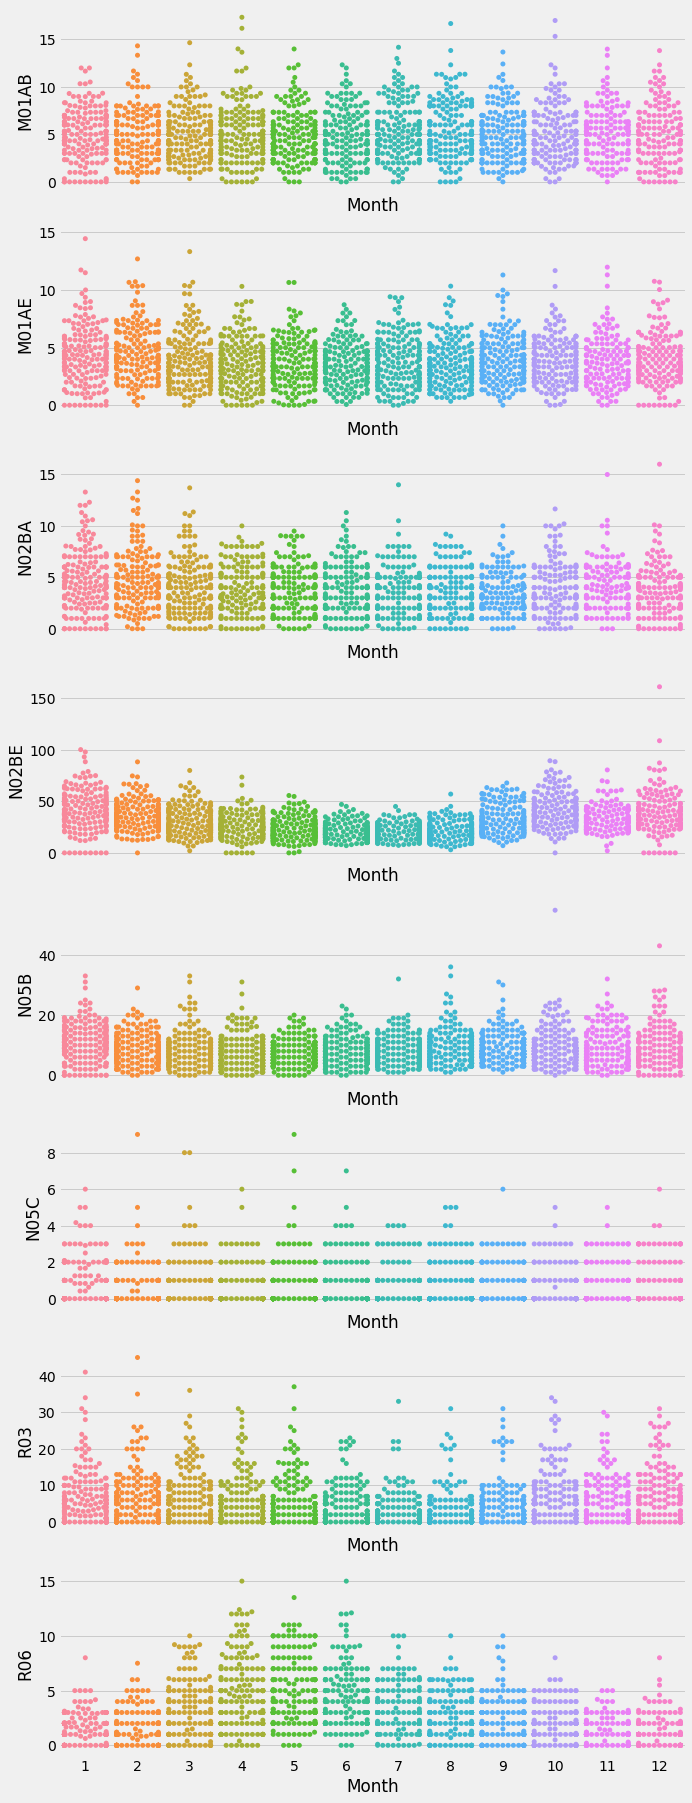

In [61]:
fig, axes = plt.subplots(8, 1, figsize=(10, 30), sharex=True)
for name, ax in zip(['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06'], axes):
    sns.swarmplot(data=dailydf, x='Month', y=name, ax=ax)
    
#save graph
plt.savefig('graphs/seasonalityAnalysis1.png')
    
    
    

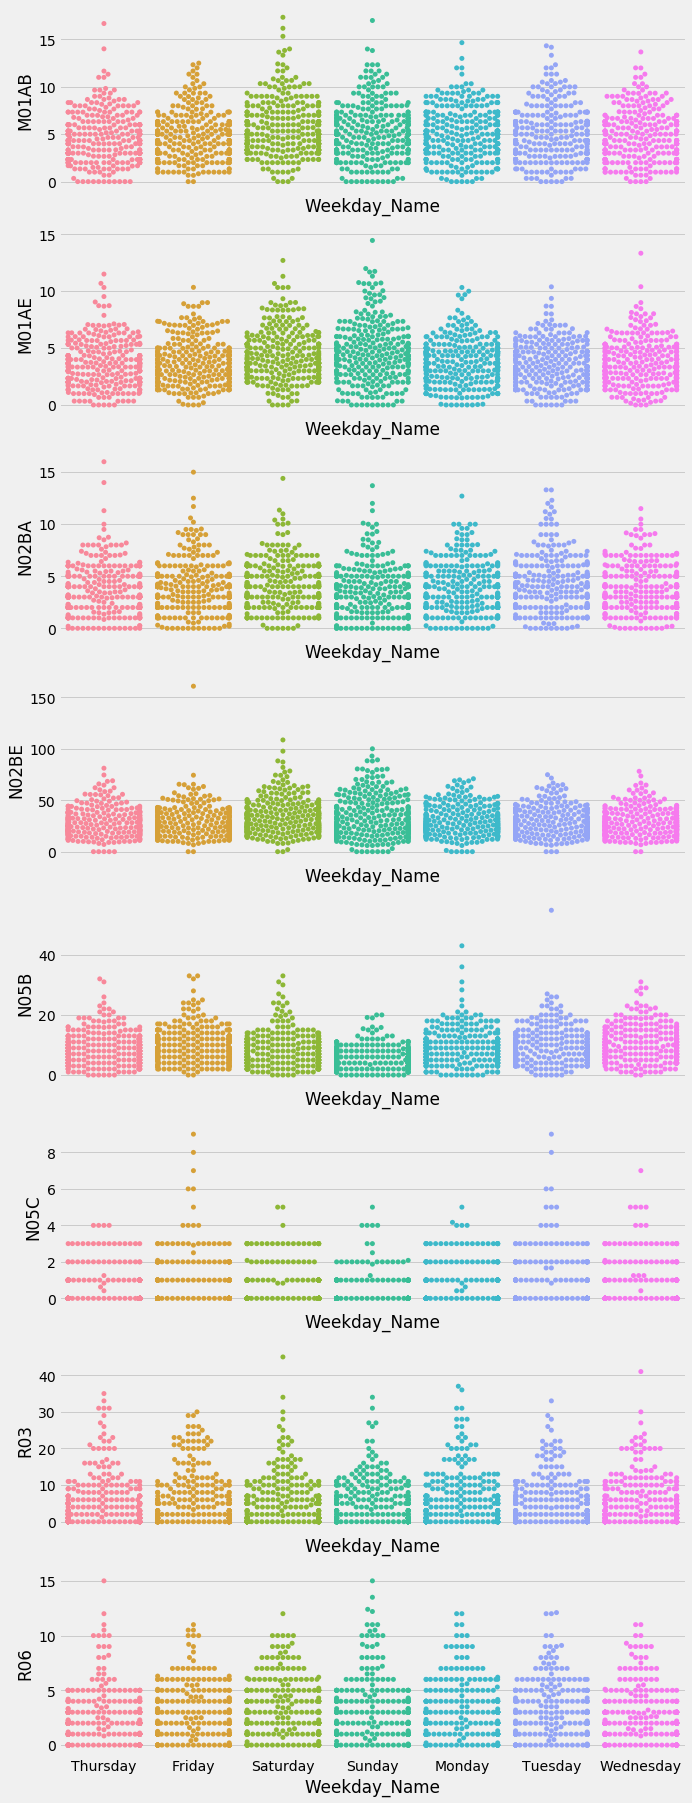

In [63]:
fig, axes = plt.subplots(8, 1, figsize=(10, 30), sharex=True)
for name, ax in zip(['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06'], axes):
    sns.swarmplot(data=dailydf, x='Weekday_Name', y=name, ax=ax)

    #save graph
plt.savefig('graphs/seasonalityAnalysis2.png')
    

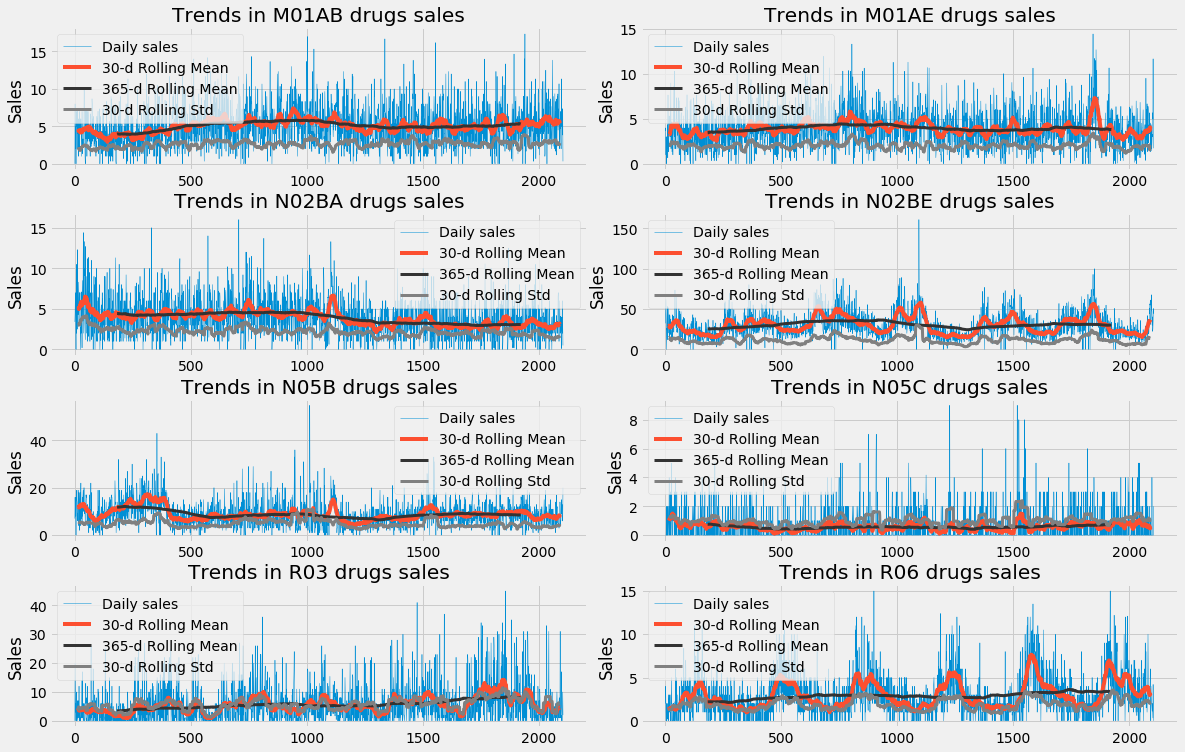

<Figure size 432x288 with 0 Axes>

In [67]:
cols_plot = ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']
dfatc_365d = dailydf[cols_plot].rolling(window=365, center=True).mean()
dfatc_30d = dailydf[cols_plot].rolling(30, center=True).mean()
dfatc_std = dailydf[cols_plot].rolling(30, center=True).std()
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18, 12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

for x in cols_plot:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    ax[rowindex,colindex].plot(dailydf.loc[:,x], linewidth=0.5, label='Daily sales')
    ax[rowindex,colindex].plot(dfatc_30d.loc[:,x], label='30-d Rolling Mean')
    ax[rowindex,colindex].plot(dfatc_365d.loc[:,x], color='0.2', linewidth=3, label='365-d Rolling Mean')
    ax[rowindex,colindex].plot(dfatc_std.loc[:,x], color='0.5', linewidth=3, label='30-d Rolling Std')
    ax[rowindex,colindex].set_ylabel('Sales')
    ax[rowindex,colindex].legend()
    ax[rowindex,colindex].set_title('Trends in '+x+' drugs sales');   
    subplotindex=subplotindex+1
plt.show()
#save graph
plt.savefig('graphs/seasonalityTrend.png')

In [ ]:
Stationarity analysis

In [ ]:
Regularity analysis

In [ ]:
Autocorrelation analysis

In [ ]:
Data distribution analysis

In [ ]:
Time series forecasting

In [ ]:
Rolling forecasting with Auto-ARIMA model

In [ ]:
Prophet forecasting

For rolling forecast, ARIMA method (Auto-ARIMA for series with seasonal character) outperforms Prophet and is considered as a best candidate for short-term sales forecasting. 
All methods in all cases (with exception of Prophet N02BE) outperform reference benchmarks - Naive and Seasonal Naive forecasts.

In [11]:
#users = pd.read_csv('users.dat',sep='::',engine= 'python' ,header = None,names=unames)

In [33]:
unames = ['user_id', 'gender', 'age', 'occupation', 'zip']
users = pd.read_csv('users.dat', sep='::', header=None, engine= 'python', names=unames)
users[:5]

,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [34]:
rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('ratings.dat', sep='::', header=None, engine= 'python', names=rnames)
ratings[:5]

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [36]:
mnames = ['movie_id', 'title', 'genres']

movies = pd.read_csv('movies.dat', sep='::', engine= 'python', header=None, names=mnames)
movies[:5]

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [39]:
#Using pandas’s merge function, we first merge ratings with users then merging that result with 
#the movies data. pandas infers which columns to use as the merge (or join) keys based on overlapping names:

data = pd.merge(pd.merge(ratings, users), movies)
data.head(10)

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama
5,18,1193,4,978156168,F,18,3,95825,One Flew Over the Cuckoo's Nest (1975),Drama
6,19,1193,5,982730936,M,1,10,48073,One Flew Over the Cuckoo's Nest (1975),Drama
7,24,1193,5,978136709,F,25,7,10023,One Flew Over the Cuckoo's Nest (1975),Drama
8,28,1193,3,978125194,F,25,1,14607,One Flew Over the Cuckoo's Nest (1975),Drama
9,33,1193,5,978557765,M,45,3,55421,One Flew Over the Cuckoo's Nest (1975),Drama


In [41]:
data.describe()

,user_id,movie_id,rating,timestamp,age,occupation
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08,2.973831e+01,8.036138e+00
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07,1.175198e+01,6.531336e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08,1.000000e+00,0.000000e+00
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08,2.500000e+01,2.000000e+00
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08,2.500000e+01,7.000000e+00
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08,3.500000e+01,1.400000e+01
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09,5.600000e+01,2.000000e+01


In [43]:
data.nunique()

user_id         6040
movie_id        3706
rating             5
timestamp     458455
gender             2
age                7
occupation        21
zip             3439
title           3706
genres           301
dtype: int64

In [48]:
data.loc[0]

user_id                                            1
movie_id                                        1193
rating                                             5
timestamp                                  978300760
gender                                             F
age                                                1
occupation                                        10
zip                                            48067
title         One Flew Over the Cuckoo's Nest (1975)
genres                                         Drama
Name: 0, dtype: object

In [70]:
mean_ratings = data.pivot_table('rating', index='title', columns='gender', aggfunc='mean')
mean_ratings[:5]

gender,F,M
title,,
"$1,000,000 Duck (1971)",3.375000,2.761905
'Night Mother (1986),3.388889,3.352941
'Til There Was You (1997),2.675676,2.733333
"'burbs, The (1989)",2.793478,2.962085
...And Justice for All (1979),3.828571,3.689024


In [71]:
ratings_by_title = data.groupby('title').size()

In [72]:
ratings_by_title[:10]

title
$1,000,000 Duck (1971)                37
'Night Mother (1986)                  70
'Til There Was You (1997)             52
'burbs, The (1989)                   303
...And Justice for All (1979)        199
1-900 (1994)                           2
10 Things I Hate About You (1999)    700
101 Dalmatians (1961)                565
101 Dalmatians (1996)                364
12 Angry Men (1957)                  616
dtype: int64

In [73]:
active_titles = ratings_by_title.index[ratings_by_title >= 250]

In [74]:
active_titles

Index([''burbs, The (1989)', '10 Things I Hate About You (1999)',
       '101 Dalmatians (1961)', '101 Dalmatians (1996)', '12 Angry Men (1957)',
       '13th Warrior, The (1999)', '2 Days in the Valley (1996)',
       '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)',
       '2010 (1984)',
       ...
       'X-Men (2000)', 'Year of Living Dangerously (1982)',
       'Yellow Submarine (1968)', 'You've Got Mail (1998)',
       'Young Frankenstein (1974)', 'Young Guns (1988)',
       'Young Guns II (1990)', 'Young Sherlock Holmes (1985)',
       'Zero Effect (1998)', 'eXistenZ (1999)'],
      dtype='object', name='title', length=1216)

In [76]:
mean_ratings = mean_ratings.loc[active_titles]

In [78]:
mean_ratings[:5]

gender,F,M
title,,
"'burbs, The (1989)",2.793478,2.962085
10 Things I Hate About You (1999),3.646552,3.311966
101 Dalmatians (1961),3.791444,3.500000
101 Dalmatians (1996),3.240000,2.911215
12 Angry Men (1957),4.184397,4.328421


In [79]:
top_female_ratings = mean_ratings.sort_values(by='F', ascending=False)

In [80]:
top_female_ratings[:10]

gender,F,M
title,,
"Close Shave, A (1995)",4.644444,4.473795
"Wrong Trousers, The (1993)",4.588235,4.478261
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.572650,4.464589
Wallace & Gromit: The Best of Aardman Animation (1996),4.563107,4.385075
Schindler's List (1993),4.562602,4.491415
"Shawshank Redemption, The (1994)",4.539075,4.560625
"Grand Day Out, A (1992)",4.537879,4.293255
To Kill a Mockingbird (1962),4.536667,4.372611
Creature Comforts (1990),4.513889,4.272277


## Measuring rating disagreement

Suppose you wanted to find the movies that are most divisive between male and female
viewers. One way is to add a column to mean_ratings containing the difference in
means, then sort by that:

In [81]:
mean_ratings['diff'] = mean_ratings['M'] - mean_ratings['F']

In [84]:
sorted_by_diff = mean_ratings.sort_values(by='diff')
sorted_by_diff[:15]

gender,F,M,diff
title,,,
Dirty Dancing (1987),3.790378,2.959596,-0.830782
Jumpin' Jack Flash (1986),3.254717,2.578358,-0.676359
Grease (1978),3.975265,3.367041,-0.608224
Little Women (1994),3.870588,3.321739,-0.548849
Steel Magnolias (1989),3.901734,3.365957,-0.535777
Anastasia (1997),3.800000,3.281609,-0.518391
"Rocky Horror Picture Show, The (1975)",3.673016,3.160131,-0.512885
"Color Purple, The (1985)",4.158192,3.659341,-0.498851
"Age of Innocence, The (1993)",3.827068,3.339506,-0.487561


Reversing the order of the rows and again slicing off the top 15 rows, we get the movies
preferred by men that women didn’t rate as highly:

In [86]:
# Reverse order of rows, take first 15 rows
sorted_by_diff[::-1][:15]

gender,F,M,diff
title,,,
"Good, The Bad and The Ugly, The (1966)",3.494949,4.221300,0.726351
"Kentucky Fried Movie, The (1977)",2.878788,3.555147,0.676359
Dumb & Dumber (1994),2.697987,3.336595,0.638608
"Longest Day, The (1962)",3.411765,4.031447,0.619682
"Cable Guy, The (1996)",2.250000,2.863787,0.613787
Evil Dead II (Dead By Dawn) (1987),3.297297,3.909283,0.611985
"Hidden, The (1987)",3.137931,3.745098,0.607167
Rocky III (1982),2.361702,2.943503,0.581801
Caddyshack (1980),3.396135,3.969737,0.573602


In [87]:
# Standard deviation of rating grouped by title
rating_std_by_title = data.groupby('title')['rating'].std()

In [89]:
# Filter down to active_titles
rating_std_by_title = rating_std_by_title.loc[active_titles]

In [91]:
# Order Series by value in descending order
rating_std_by_title.sort_values(ascending=False)[:10]

title
Dumb & Dumber (1994)                     1.321333
Blair Witch Project, The (1999)          1.316368
Natural Born Killers (1994)              1.307198
Tank Girl (1995)                         1.277695
Rocky Horror Picture Show, The (1975)    1.260177
Eyes Wide Shut (1999)                    1.259624
Evita (1996)                             1.253631
Billy Madison (1995)                     1.249970
Fear and Loathing in Las Vegas (1998)    1.246408
Bicentennial Man (1999)                  1.245533
Name: rating, dtype: float64